Sample movies data:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water             None   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans             None   
4      s5  TV Show           Kota Factory             None   

                                                cast        country  \
0  Michael Hilow, Ana Hoffman, Dick Johnson, Kirs...  United States   
1  Ama Qamata Khosi Ngema Gail Mabalane Thabang M...   South Africa   
2  Sami Bouajila Tracy Gotoas Samuel Jouy Nabiha ...           None   
3                                               None           None   
4  Mayur More Jitendra Kumar Ranjan Raj Alam Khan...          India   

   release_year rating   duration  \
0          2020  PG-13     90 min   
1          2021  TV-MA  2 Seasons   
2          2021  TV-MA   1 Season   
3          2021  TV-MA   1 Seaso

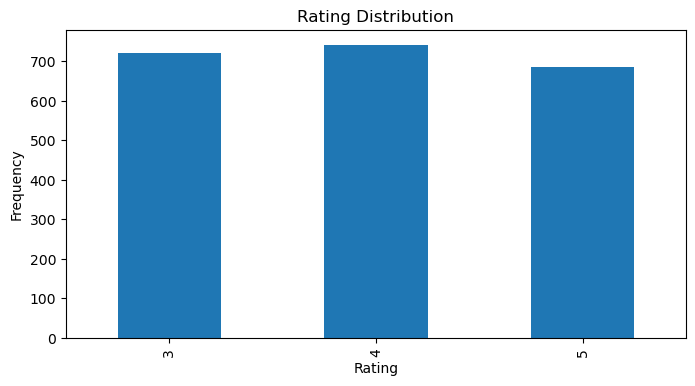


Number of unique movies: 8508
Number of unique users: 200
Number of ratings: 2147
Average ratings per user: 10.73
Average ratings per movie: 0.25


In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Data Understanding:
# Step 1: Load the data from the SQLite database.
conn = sqlite3.connect('../notebooks/Movies.db')

# Load the movies, ratings, and users data
movies = pd.read_sql_query("SELECT * FROM movies_titles;", conn)
ratings = pd.read_sql_query("SELECT * FROM movies_ratings;", conn)
users = pd.read_sql_query("SELECT * FROM movies_users;", conn)

# Close the connection
conn.close()

# Display data samples
print("Sample movies data:")
print(movies.head())
print("\nSample ratings data:")
print(ratings.head())
print("\nSample users data:")
print(users.head())

# Data Visualization: Distribution of ratings
plt.figure(figsize=(8, 4))
ratings['rating'].value_counts().sort_index().plot(kind='bar')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# Data Understanding: Key Metrics
print("\nNumber of unique movies:", len(movies['show_id'].unique()))
print("Number of unique users:", len(users['user_id'].unique()))
print("Number of ratings:", len(ratings))
print("Average ratings per user:", round(len(ratings) / len(users), 2))
print("Average ratings per movie:", round(len(ratings) / len(movies), 2))

In [ ]:
# making sure the rating frequency is accurate

# Connect to the SQLite database
conn = sqlite3.connect('Movies.db')

# Check unique ratings
query = "SELECT DISTINCT rating FROM movies_ratings;"
unique_ratings = pd.read_sql_query(query, conn)

# Check the distribution of ratings
rating_distribution = pd.read_sql_query("SELECT rating, COUNT(*) as count FROM movies_ratings GROUP BY rating;", conn)

# Close the connection
conn.close()

print("Unique ratings in the dataset:")
print(unique_ratings)
print("\nRating distribution:")
print(rating_distribution)

Unique ratings in the dataset:
   rating
0       4
1       5
2       3

Rating distribution:
   rating  count
0       3    721
1       4    742
2       5    684


In [2]:
# Data Preparation:
# Step 1: Clean the data by filling missing values
movies['title'].fillna('Unknown', inplace=True)
movies['director'].fillna('Unknown', inplace=True)
movies['cast'].fillna('Unknown', inplace=True)

# Combine relevant features for content-based filtering
movies['combined_features'] = movies['title'] + ' ' + movies['director'] + ' ' + movies['cast']

# Step 2: Handle missing values in the user data
users.fillna('Unknown', inplace=True)

# Step 3: Removing duplicate ratings
print(f"Duplicate ratings before cleaning: {ratings.duplicated(subset=['user_id', 'show_id']).sum()}")
ratings.drop_duplicates(subset=['user_id', 'show_id'], keep='first', inplace=True)
print(f"Duplicate ratings after cleaning: {ratings.duplicated(subset=['user_id', 'show_id']).sum()}")

# Step 4: Verifying data after cleaning
print("Movies data after cleaning:")
print(movies.head())
print("\nUsers data after cleaning:")
print(users.head())

# Data Insight:
print("\nData Cleaning Complete. Missing values handled and duplicates removed.")

Duplicate ratings before cleaning: 0
Duplicate ratings after cleaning: 0
Movies data after cleaning:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water          Unknown   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans          Unknown   
4      s5  TV Show           Kota Factory          Unknown   

                                                cast        country  \
0  Michael Hilow, Ana Hoffman, Dick Johnson, Kirs...  United States   
1  Ama Qamata Khosi Ngema Gail Mabalane Thabang M...   South Africa   
2  Sami Bouajila Tracy Gotoas Samuel Jouy Nabiha ...           None   
3                                            Unknown           None   
4  Mayur More Jitendra Kumar Ranjan Raj Alam Khan...          India   

   release_year rating   duration  \
0          2020  PG-13     90 min   
1          2021  TV-MA  2

C:\Users\mclai\AppData\Local\Temp\ipykernel_36676\3269025499.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies['title'].fillna('Unknown', inplace=True)
C:\Users\mclai\AppData\Local\Temp\ipykernel_36676\3269025499.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

In [ ]:
# collaborative filtering

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a user-item matrix for collaborative filtering
user_movie_matrix = ratings.pivot_table(index='user_id', columns='show_id', values='rating').fillna(0)

# Calculate similarity between users
user_similarity = cosine_similarity(user_movie_matrix)

def collaborative_recommendations(user_id, num_recommendations=5):
    try:
        user_index = user_movie_matrix.index.get_loc(user_id)
        sim_scores = list(enumerate(user_similarity[user_index]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
        similar_users = [user_movie_matrix.index[i[0]] for i in sim_scores]
        similar_users_ratings = user_movie_matrix.loc[similar_users].mean(axis=0)
        recommended_movies = similar_users_ratings.sort_values(ascending=False).head(num_recommendations)
        return movies[movies['show_id'].isin(recommended_movies.index)]['title'].tolist()
    except Exception:
        return ['None'] * num_recommendations

In [5]:
# content-based filtering

# TF-IDF Vectorizer for movie features
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['combined_features'])

# Cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def content_recommendations(movie_title, num_recommendations=5):
    try:
        idx = movies[movies['title'] == movie_title].index[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
        movie_indices = [i[0] for i in sim_scores]
        return movies['title'].iloc[movie_indices].tolist()
    except IndexError:
        return ['None'] * num_recommendations

In [6]:
# Hybrid

def hybrid_recommendations(user_id, movie_title, num_recommendations=5):
    collab = collaborative_recommendations(user_id, num_recommendations)
    content = content_recommendations(movie_title, num_recommendations)
    combined = list(set(collab + content))[:num_recommendations]
    return combined

In [ ]:
# deployment

def generate_home_recommendations(user_id, movie_title):
    collab_recs = collaborative_recommendations(user_id)
    content_recs = content_recommendations(movie_title)
    hybrid_recs = hybrid_recommendations(user_id, movie_title)

    recommendations = {
        'user_id': user_id,
        'collaborative': collab_recs,
        'content': content_recs,
        'hybrid': hybrid_recs
    }
    
    return recommendations

# Save the recommendations to a CSV file
user_ids = users['user_id'].unique()
recommendations_list = []

for user_id in user_ids[:200]:  # Limiting to first 50 users for demonstration
    recs = generate_home_recommendations(user_id, "Inception")
    recommendations_list.append(recs)

home_recs_df = pd.DataFrame(recommendations_list)
home_recs_df.to_csv('home_recommendations.csv', index=False)
print("Home page recommendations saved to home_recommendations.csv")

Home page recommendations saved to home_recommendations.csv


In [11]:
# Automation:
def run_home_recommendation_pipeline():
    print("Generating home page recommendations...")
    generate_home_recommendations(1, "Inception")
    print("Recommendations saved successfully!")

run_home_recommendation_pipeline()

Generating home page recommendations...
Recommendations saved successfully!


In [12]:
# Connect to the SQLite database
conn = sqlite3.connect('Movies.db')

# Count the number of unique users
query = "SELECT COUNT(DISTINCT user_id) AS user_count FROM movies_users;"
user_count = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

print(f"Number of unique users: {user_count['user_count'][0]}")

Number of unique users: 200
